# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import retry
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")
current_hour = datetime.datetime.utcnow().hour
are_today_results_partial = current_hour != 23

### Constants

In [3]:
from Modules.ExposureNotification import exposure_notification_io

spain_region_country_code = "ES"
germany_region_country_code = "DE"

default_backend_identifier = spain_region_country_code

backend_generation_days = 7 * 2
daily_summary_days = 7 * 4 * 3
daily_plot_days = 7 * 4
tek_dumps_load_limit = daily_summary_days + 1

### Parameters

In [4]:
environment_backend_identifier = os.environ.get("RADARCOVID_REPORT__BACKEND_IDENTIFIER")
if environment_backend_identifier:
    report_backend_identifier = environment_backend_identifier
else:
    report_backend_identifier = default_backend_identifier
report_backend_identifier

'ES'

In [5]:
environment_enable_multi_backend_download = \
    os.environ.get("RADARCOVID_REPORT__ENABLE_MULTI_BACKEND_DOWNLOAD")
if environment_enable_multi_backend_download:
    report_backend_identifiers = None
else:
    report_backend_identifiers = [report_backend_identifier]

report_backend_identifiers

In [6]:
environment_invalid_shared_diagnoses_dates = \
    os.environ.get("RADARCOVID_REPORT__INVALID_SHARED_DIAGNOSES_DATES")
if environment_invalid_shared_diagnoses_dates:
    invalid_shared_diagnoses_dates = environment_invalid_shared_diagnoses_dates.split(",")
else:
    invalid_shared_diagnoses_dates = []

invalid_shared_diagnoses_dates

['2020-10-30']

### COVID-19 Cases

In [7]:
report_backend_client = \
    exposure_notification_io.get_backend_client_with_identifier(
        backend_identifier=report_backend_identifier)

In [8]:
@retry.retry(tries=10, delay=10, backoff=1.1, jitter=(0, 10))
def download_cases_dataframe_from_ecdc():
    return pd.read_csv(
        "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv")

confirmed_df_ = download_cases_dataframe_from_ecdc()

In [9]:
confirmed_df = confirmed_df_.copy()
confirmed_df = confirmed_df[["dateRep", "cases", "geoId"]]
confirmed_df.rename(
    columns={
        "dateRep":"sample_date",
        "cases": "new_cases",
        "geoId": "country_code",
    },
    inplace=True)
confirmed_df["sample_date"] = pd.to_datetime(confirmed_df.sample_date, dayfirst=True)
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases,country_code
49642,2020-11-04,128,UG
7221,2020-11-04,0,VG
34690,2020-11-04,7729,NL
41320,2020-11-04,13,LC
0,2020-11-04,86,AF


In [10]:
confirmed_days = pd.date_range(
    start=confirmed_df.iloc[0].sample_date,
    end=extraction_datetime)
source_regions_at_date_df = pd.DataFrame(data=confirmed_days, columns=["sample_date"])
source_regions_at_date_df["source_regions_at_date"] = \
    source_regions_at_date_df.sample_date.apply(
        lambda x: report_backend_client.source_regions_for_date(date=x))
source_regions_at_date_df.sort_values("sample_date", inplace=True)
source_regions_at_date_df.tail()

,sample_date,source_regions_at_date
305,2020-10-31,"{ES, LV, IT, DE, IE}"
306,2020-11-01,"{ES, LV, IT, DE, IE}"
307,2020-11-02,"{ES, LV, IT, DE, IE}"
308,2020-11-03,"{ES, LV, IT, DE, IE}"
309,2020-11-04,"{ES, LV, IT, DE, IE}"


In [11]:
confirmed_df = source_regions_at_date_df.merge(confirmed_df, how="left")
confirmed_df = confirmed_df[confirmed_df.apply(
    lambda x: x.country_code in x.source_regions_at_date, axis=1)]
confirmed_df.drop(columns=["source_regions_at_date"], inplace=True)
confirmed_df = source_regions_at_date_df.merge(confirmed_df, how="left")
confirmed_df["sample_date"] = confirmed_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,source_regions_at_date,new_cases,country_code
327,2020-11-03,"{ES, LV, IT, DE, IE}",18669,ES
330,2020-11-04,"{ES, LV, IT, DE, IE}",17214,DE
331,2020-11-04,"{ES, LV, IT, DE, IE}",28241,IT
329,2020-11-04,"{ES, LV, IT, DE, IE}",171,LV
332,2020-11-04,"{ES, LV, IT, DE, IE}",298,IE


In [12]:
def sort_source_regions_for_display(source_regions: list) -> list:
    if report_backend_identifier in source_regions:
        source_regions = [report_backend_identifier] + \
            list(sorted(set(source_regions).difference([report_backend_identifier])))
    else:
        source_regions = list(sorted(source_regions))
    return source_regions

report_source_regions = confirmed_df.country_code.dropna().unique().tolist()
report_source_regions = sort_source_regions_for_display(
    source_regions=report_source_regions)

In [13]:
confirmed_df["_source_regions_group"] = confirmed_df.source_regions_at_date.apply(
    lambda x: ",".join(sort_source_regions_for_display(x)))
confirmed_df = confirmed_df.groupby(["sample_date", "_source_regions_group"]).new_cases.sum(min_count=1).reset_index()
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,_source_regions_group,new_cases
305,2020-10-31,"ES,DE,IE,IT,LV",51184
306,2020-11-01,"ES,DE,IE,IT,LV",46545
307,2020-11-02,"ES,DE,IE,IT,LV",97809
308,2020-11-03,"ES,DE,IE,IT,LV",57154
309,2020-11-04,"ES,DE,IE,IT,LV",45924


In [14]:
confirmed_output_columns = ["sample_date", "new_cases", "covid_cases"]
confirmed_output_df = pd.DataFrame(columns=confirmed_output_columns)
for source_regions_group in confirmed_df._source_regions_group.unique().tolist():
    confirmed_source_regions_group_df = \
        confirmed_df[confirmed_df._source_regions_group == source_regions_group].copy()
    confirmed_df.sort_values("sample_date", inplace=True)
    confirmed_source_regions_group_df["covid_cases"] = \
        confirmed_source_regions_group_df.new_cases.rolling(7, min_periods=0).mean().round()
    confirmed_source_regions_group_df = \
        confirmed_source_regions_group_df[confirmed_output_columns]
    confirmed_source_regions_group_df.fillna(method="ffill", inplace=True)
    confirmed_output_df = confirmed_output_df.append(confirmed_source_regions_group_df)

confirmed_df = confirmed_output_df.copy()
confirmed_df.tail()

,sample_date,new_cases,covid_cases
305,2020-10-31,51184,61702.0
306,2020-11-01,46545,56649.0
307,2020-11-02,97809,66939.0
308,2020-11-03,57154,64982.0
309,2020-11-04,45924,61806.0


In [15]:
confirmed_df.rename(columns={"sample_date": "sample_date_string"}, inplace=True)
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df.tail()

,sample_date_string,new_cases,covid_cases
305,2020-10-31,51184,61702.0
306,2020-11-01,46545,56649.0
307,2020-11-02,97809,66939.0
308,2020-11-03,57154,64982.0
309,2020-11-04,45924,61806.0


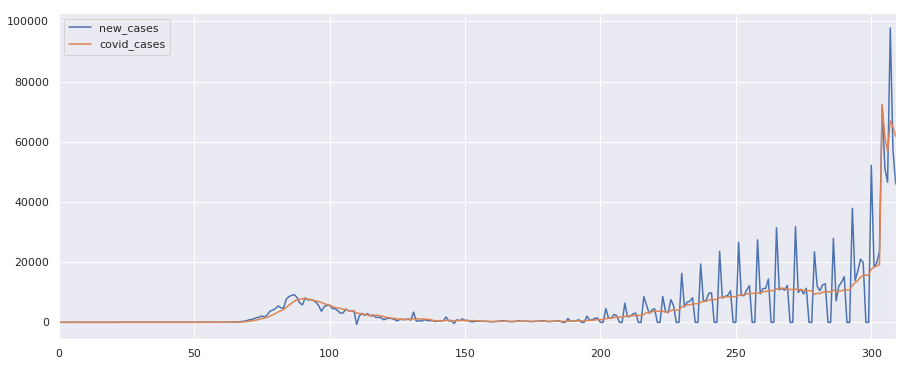

In [16]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [17]:
raw_zip_path_prefix = "Data/TEKs/Raw/"
fail_on_error_backend_identifiers = [report_backend_identifier]
multi_backend_exposure_keys_df = \
    exposure_notification_io.download_exposure_keys_from_backends(
        backend_identifiers=report_backend_identifiers,
        generation_days=backend_generation_days,
        fail_on_error_backend_identifiers=fail_on_error_backend_identifiers,
        save_raw_zip_path_prefix=raw_zip_path_prefix)
multi_backend_exposure_keys_df["region"] = multi_backend_exposure_keys_df["backend_identifier"]
multi_backend_exposure_keys_df.rename(
    columns={
        "generation_datetime": "sample_datetime",
        "generation_date_string": "sample_date_string",
    },
    inplace=True)
multi_backend_exposure_keys_df.head()

,sample_datetime,sample_date_string,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level,backend_identifier
0,2020-11-04,2020-11-04,ES,V1,214,1.2.840.10045.4.3.2,fb5343f6-448d-214d-987f-09eca54eb9f2,2674080,131,0,ES
1,2020-11-04,2020-11-04,ES,V1,214,1.2.840.10045.4.3.2,f326427f-90c2-37ab-343e-abc53f3849eb,2674080,131,0,ES
2,2020-11-04,2020-11-04,ES,V1,214,1.2.840.10045.4.3.2,1131a1aa-601d-29df-416b-b024df19bb61,2674080,144,0,ES
3,2020-11-04,2020-11-04,ES,V1,214,1.2.840.10045.4.3.2,7d9e5037-961d-c509-702e-788886397a3a,2674080,129,0,ES
4,2020-11-04,2020-11-04,ES,V1,214,1.2.840.10045.4.3.2,0fc0a41e-7276-499c-e12e-819037729b5d,2674080,127,0,ES


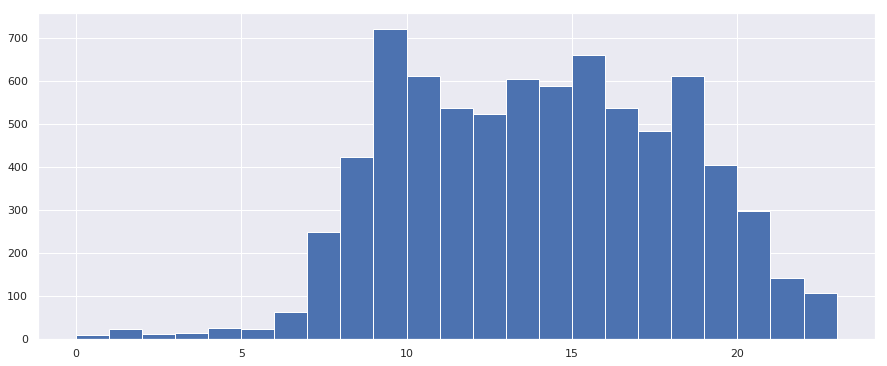

In [18]:
early_teks_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.rolling_period < 144].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

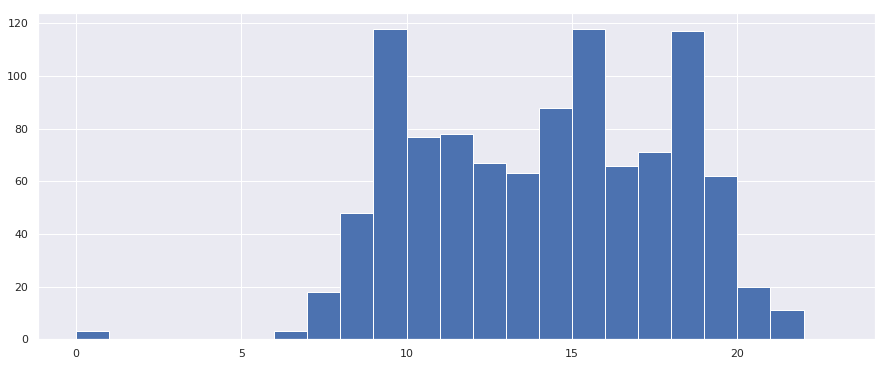

In [19]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [20]:
multi_backend_exposure_keys_df = multi_backend_exposure_keys_df[[
    "sample_date_string", "region", "key_data"]]
multi_backend_exposure_keys_df.head()

,sample_date_string,region,key_data
0,2020-11-04,ES,fb5343f6-448d-214d-987f-09eca54eb9f2
1,2020-11-04,ES,f326427f-90c2-37ab-343e-abc53f3849eb
2,2020-11-04,ES,1131a1aa-601d-29df-416b-b024df19bb61
3,2020-11-04,ES,7d9e5037-961d-c509-702e-788886397a3a
4,2020-11-04,ES,0fc0a41e-7276-499c-e12e-819037729b5d


In [21]:
active_regions = \
    multi_backend_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['EE', 'BE@TST', 'MT', 'PT', 'DK', 'BE', 'ES@PRE', 'CH', 'DE', 'IT', 'ES']

In [22]:
multi_backend_summary_df = multi_backend_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_backend_summary_df.rename(
    columns={"key_data": "shared_teks_by_generation_date"},
    inplace=True)
multi_backend_summary_df.rename_axis("sample_date", inplace=True)
multi_backend_summary_df = multi_backend_summary_df.fillna(0).astype(int)
multi_backend_summary_df = multi_backend_summary_df.head(backend_generation_days)
multi_backend_summary_df.head()

shared_teks_by_generation_date                                    \
region                                  BE BE@TST    CH    DE   DK  EE    ES   
sample_date                                                                    
2020-11-04                               0      0   651     0    0   0   344   
2020-11-03                               0      0  1970     0    0  10  2118   
2020-11-02                             277     46  2948  2206  203  19  4440   
2020-11-01                             355     47  3670  3692  398  29  5916   
2020-10-31                             504     40  4278  5053  533  31  7371   

                                    
region      ES@PRE    IT   MT   PT  
sample_date                         
2020-11-04       3    32    0    0  
2020-11-03     243  2285  115  123  
2020-11-02     512  4397  119  172  
2020-11-01     761  5661  124  239  
2020-10-31    1004  6950  127  275

In [23]:
def compute_keys_cross_sharing(x):
    teks_x = x.key_data_x.item()
    common_teks = set(teks_x).intersection(x.key_data_y.item())
    common_teks_fraction = len(common_teks) / len(teks_x)
    return pd.Series(dict(
        common_teks=common_teks,
        common_teks_fraction=common_teks_fraction,
    ))

multi_backend_exposure_keys_by_region_df = \
    multi_backend_exposure_keys_df.groupby("region").key_data.unique().reset_index()
multi_backend_exposure_keys_by_region_df["_merge"] = True
multi_backend_exposure_keys_by_region_combination_df = \
    multi_backend_exposure_keys_by_region_df.merge(
        multi_backend_exposure_keys_by_region_df, on="_merge")
multi_backend_exposure_keys_by_region_combination_df.drop(
    columns=["_merge"], inplace=True)
if multi_backend_exposure_keys_by_region_combination_df.region_x.nunique() > 1:
    multi_backend_exposure_keys_by_region_combination_df = \
        multi_backend_exposure_keys_by_region_combination_df[
            multi_backend_exposure_keys_by_region_combination_df.region_x !=
            multi_backend_exposure_keys_by_region_combination_df.region_y]
multi_backend_exposure_keys_cross_sharing_df = \
    multi_backend_exposure_keys_by_region_combination_df \
        .groupby(["region_x", "region_y"]) \
        .apply(compute_keys_cross_sharing) \
        .reset_index()
multi_backend_cross_sharing_summary_df = \
    multi_backend_exposure_keys_cross_sharing_df.pivot_table(
        values=["common_teks_fraction"],
        columns="region_x",
        index="region_y",
        aggfunc=lambda x: x.item())
multi_backend_cross_sharing_summary_df

<ipython-input-23-4e21708c19d8>:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  teks_x = x.key_data_x.item()
<ipython-input-23-4e21708c19d8>:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  common_teks = set(teks_x).intersection(x.key_data_y.item())


<ipython-input-23-4e21708c19d8>:33: FutureWarning: `item` has been deprecated and will be removed in a future version
  aggfunc=lambda x: x.item())


common_teks_fraction                                                 \
region_x                   BE BE@TST        CH        DE   DK   EE        ES   
region_y                                                                       
BE                        NaN    0.0  0.000000  0.000000  0.0  0.0  0.000000   
BE@TST                    0.0    NaN  0.000000  0.000000  0.0  0.0  0.000000   
CH                        0.0    0.0       NaN  0.000126  0.0  0.0  0.000103   
DE                        0.0    0.0  0.000257       NaN  0.0  0.0  0.750725   
DK                        0.0    0.0  0.000000  0.000000  NaN  0.0  0.000000   
EE                        0.0    0.0  0.000000  0.000000  0.0  NaN  0.000000   
ES                        0.0    0.0  0.000257  0.913312  0.0  0.0       NaN   
ES@PRE                    0.0    0.0  0.000000  0.000000  0.0  0.0  0.000058   
IT                        0.0    0.0  0.000257  0.926822  0.0  0.0  0.903759   
MT                        0.0    0.0  0.000000  0.000000  0.0  0.0  0.000000   
PT                        0.0    0.0  0.000000  0.000000  0.0  0.0  0.000000   

                                        
region_x    ES@PRE        IT   MT   PT  
region_y                                
BE        0.000000  0.000000  0.0  0.0  
BE@TST    0.000000  0.000000  0.0  0.0  
CH        0.000000  0.000108  0.0  0.0  
DE        0.000000  0.795371  0.0  0.0  
DK        0.000000  0.000000  0.0  0.0  
EE        0.000000  0.000000  0.0  0.0  
ES        0.000423  0.943550  0.0  0.0  
ES@PRE         NaN  0.000000  0.0  0.0  
IT        0.000000       NaN  0.0  0.0  
MT        0.000000  0.000000  NaN  0.0  
PT        0.000000  0.000000  0.0  NaN

In [24]:
multi_backend_without_active_region_exposure_keys_df = \
    multi_backend_exposure_keys_df[multi_backend_exposure_keys_df.region != report_backend_identifier]
multi_backend_without_active_region = \
    multi_backend_without_active_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
multi_backend_without_active_region

['EE', 'BE@TST', 'MT', 'PT', 'DK', 'BE', 'ES@PRE', 'CH', 'DE', 'IT']

In [25]:
exposure_keys_summary_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.region == report_backend_identifier]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,shared_teks_by_generation_date
sample_date_string,
2020-11-04,344
2020-11-03,2118
2020-11-02,4440
2020-11-01,5916
2020-10-31,7371


### Dump API TEKs

In [26]:
tek_list_df = multi_backend_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour

tek_list_path_prefix = "Data/TEKs/"
tek_list_current_path = tek_list_path_prefix + f"/Current/RadarCOVID-TEKs.json"
tek_list_daily_path = tek_list_path_prefix + f"Daily/RadarCOVID-TEKs-{extraction_date}.json"
tek_list_hourly_path = tek_list_path_prefix + f"Hourly/RadarCOVID-TEKs-{extraction_date_with_hour}.json"

for path in [tek_list_current_path, tek_list_daily_path, tek_list_hourly_path]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    tek_list_current_path,
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    tek_list_daily_path,
    lines=True, orient="records")
tek_list_df.to_json(
    tek_list_hourly_path,
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-10-22,BE,"[00013df9-4b00-dc7f-24a6-0a583383eb7e, 0024e55...",2020-11-04,2020-11-04@23
1,2020-10-22,BE@TST,"[002730e9-6bbf-cd0e-565d-ce1f37793576, 024f90b...",2020-11-04,2020-11-04@23
2,2020-10-22,CH,"[0f445727-d11a-deb0-6c71-d3b585da64bb, 0082fa7...",2020-11-04,2020-11-04@23
3,2020-10-22,DE,"[001c64bb-b5c8-2391-bbe1-18a771d4e1bb, 0033400...",2020-11-04,2020-11-04@23
4,2020-10-22,DK,"[2e07e206-34de-c4a9-35d4-1cf38356cc25, a9a60d1...",2020-11-04,2020-11-04@23


### Load TEK Dumps

In [27]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    file_paths = list(reversed(sorted(glob.glob(tek_list_path_prefix + mode + "/RadarCOVID-TEKs-*.json"))))
    if limit:
        file_paths = file_paths[:limit]
    for file_path in file_paths:
        logging.info(f"Loading TEKs from '{file_path}'...")
        iteration_extracted_teks_df = pd.read_json(file_path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [28]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=report_backend_identifier,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
6,ES,2020-10-22,"[6afe521e-39c9-ee35-ee27-dfc2eccf1dde, a7b9db7...",2020-11-04,NaN
17,ES,2020-10-23,"[722b5b41-64da-8d23-157c-acf06f969ab6, 00683ba...",2020-11-04,NaN
28,ES,2020-10-24,"[58f0c077-0497-2bad-d3e4-56308a9c4be0, 871c958...",2020-11-04,NaN
39,ES,2020-10-25,"[31247f9f-4cb0-37e3-be6c-e76f19429baa, 7bd4cda...",2020-11-04,NaN
50,ES,2020-10-26,"[270ada5a-caa5-39ca-7426-31a00fcfc41a, b9d1ef7...",2020-11-04,NaN


In [29]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-11-04,344
2020-11-03,2118
2020-11-02,4440
2020-11-01,5916
2020-10-31,7371


### Daily New TEKs

In [30]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{8647bd94-5658-5fde-9031-3ddb5a9e64fb, 14ae162..."
2020-08-30,"{8647bd94-5658-5fde-9031-3ddb5a9e64fb, 14ae162..."
2020-08-31,"{8647bd94-5658-5fde-9031-3ddb5a9e64fb, 14ae162..."
2020-09-01,"{8647bd94-5658-5fde-9031-3ddb5a9e64fb, 14ae162..."
2020-09-02,"{8647bd94-5658-5fde-9031-3ddb5a9e64fb, 14ae162..."


In [31]:
def compute_teks_by_generation_and_upload_date(date):
    day_new_teks_set_df = tek_list_df.copy().diff()
    try:
        day_new_teks_set = day_new_teks_set_df[
            day_new_teks_set_df.index == date].tek_list.item()
    except ValueError:
        day_new_teks_set = None
    if pd.isna(day_new_teks_set):
        day_new_teks_set = set()
    day_new_teks_df = daily_extracted_teks_df[
        daily_extracted_teks_df.extraction_date == date].copy()
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.tek_list.apply(lambda x: set(x).intersection(day_new_teks_set))
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.shared_teks.apply(len)
    day_new_teks_df["upload_date"] = date
    day_new_teks_df.rename(columns={"sample_date": "generation_date"}, inplace=True)
    day_new_teks_df = day_new_teks_df[
        ["upload_date", "generation_date", "shared_teks"]]
    day_new_teks_df["generation_to_upload_days"] = \
        (pd.to_datetime(day_new_teks_df.upload_date) -
         pd.to_datetime(day_new_teks_df.generation_date)).dt.days
    day_new_teks_df = day_new_teks_df[day_new_teks_df.shared_teks > 0]
    return day_new_teks_df

shared_teks_generation_to_upload_df = pd.DataFrame()
for upload_date in daily_extracted_teks_df.extraction_date.unique():
    shared_teks_generation_to_upload_df = \
        shared_teks_generation_to_upload_df.append(
            compute_teks_by_generation_and_upload_date(date=upload_date))
shared_teks_generation_to_upload_df \
    .sort_values(["upload_date", "generation_date"], ascending=False, inplace=True)
shared_teks_generation_to_upload_df.tail()

<ipython-input-31-827222b35590>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  day_new_teks_set = day_new_teks_set_df[


,upload_date,generation_date,shared_teks,generation_to_upload_days
10,2020-08-30,2020-08-29,16,1
9,2020-08-30,2020-08-28,5,2
8,2020-08-30,2020-08-27,3,3
7,2020-08-30,2020-08-26,3,4
6,2020-08-30,2020-08-25,2,5


In [32]:
today_new_teks_df = \
    shared_teks_generation_to_upload_df[
        shared_teks_generation_to_upload_df.upload_date == extraction_date].copy()
today_new_teks_df.tail()

,upload_date,generation_date,shared_teks,generation_to_upload_days
50,2020-11-04,2020-10-26,1992,9
39,2020-11-04,2020-10-25,1936,10
28,2020-11-04,2020-10-24,1890,11
17,2020-11-04,2020-10-23,1873,12
6,2020-11-04,2020-10-22,1835,13


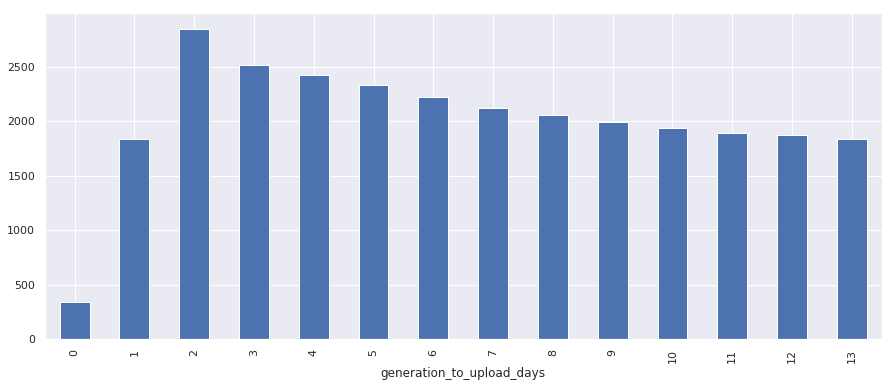

In [33]:
if not today_new_teks_df.empty:
    today_new_teks_df.set_index("generation_to_upload_days") \
        .sort_index().shared_teks.plot.bar()

In [34]:
generation_to_upload_period_pivot_df = \
    shared_teks_generation_to_upload_df[
        ["upload_date", "generation_to_upload_days", "shared_teks"]] \
        .pivot(index="upload_date", columns="generation_to_upload_days") \
        .sort_index(ascending=False).fillna(0).astype(int) \
        .droplevel(level=0, axis=1)
generation_to_upload_period_pivot_df.head()

generation_to_upload_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
upload_date,,,,,,,,,,,,,,
2020-11-04,344,1838,2851,2522,2429,2336,2226,2120,2055,1992,1936,1890,1873,1835
2020-11-03,280,1325,1961,1888,1809,1711,1642,1564,1519,1448,1414,1388,1354,1310
2020-11-02,264,1156,1711,1629,1500,1415,1314,1250,1195,1163,1129,1100,1072,1029
2020-11-01,277,1038,1842,1654,1495,1375,1302,1241,1196,1168,1123,1075,1046,1016
2020-10-31,305,1273,2163,1934,1766,1671,1578,1507,1461,1416,1370,1326,1292,1266


In [35]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
63,2020-10-31,20328.0
64,2020-11-01,16848.0
65,2020-11-02,16927.0
66,2020-11-03,20613.0
67,2020-11-04,28247.0


In [36]:
shared_teks_uploaded_on_generation_date_df = shared_teks_generation_to_upload_df[
    shared_teks_generation_to_upload_df.generation_to_upload_days == 0] \
    [["upload_date", "shared_teks"]].rename(
    columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
140,2020-11-04,344
141,2020-11-03,280
141,2020-11-02,264
142,2020-11-01,277
141,2020-10-31,305


In [37]:
estimated_shared_diagnoses_df = shared_teks_generation_to_upload_df \
    .groupby(["upload_date"]).shared_teks.max().reset_index() \
    .sort_values(["upload_date"], ascending=False) \
    .rename(columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_diagnoses",
    })
invalid_shared_diagnoses_dates_mask = \
    estimated_shared_diagnoses_df.sample_date_string.isin(invalid_shared_diagnoses_dates)
estimated_shared_diagnoses_df[invalid_shared_diagnoses_dates_mask] = 0
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
66,2020-11-04,2851
65,2020-11-03,1961
64,2020-11-02,1711
63,2020-11-01,1842
62,2020-10-31,2163


### Hourly New TEKs

In [38]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=report_backend_identifier, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
6,ES,2020-10-22,"[6afe521e-39c9-ee35-ee27-dfc2eccf1dde, a7b9db7...",2020-11-04,2020-11-04@23
17,ES,2020-10-23,"[722b5b41-64da-8d23-157c-acf06f969ab6, 00683ba...",2020-11-04,2020-11-04@23
28,ES,2020-10-24,"[58f0c077-0497-2bad-d3e4-56308a9c4be0, 871c958...",2020-11-04,2020-11-04@23
39,ES,2020-10-25,"[31247f9f-4cb0-37e3-be6c-e76f19429baa, 7bd4cda...",2020-11-04,2020-11-04@23
50,ES,2020-10-26,"[270ada5a-caa5-39ca-7426-31a00fcfc41a, b9d1ef7...",2020-11-04,2020-11-04@23


In [39]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2020-11-03@21,0
1,2020-11-03@22,56
2,2020-11-03@23,0
3,2020-11-04@00,15
4,2020-11-04@01,0


In [40]:
hourly_summary_df = hourly_new_tek_count_df.copy()
hourly_summary_df.set_index("extraction_date_with_hour", inplace=True)
hourly_summary_df = hourly_summary_df.fillna(0).astype(int).reset_index()
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
datetime_utc,,
2020-11-03 22:00:00,2020-11-03@22,56
2020-11-03 23:00:00,2020-11-03@23,0
2020-11-04 00:00:00,2020-11-04@00,15
2020-11-04 01:00:00,2020-11-04@01,0
2020-11-04 02:00:00,2020-11-04@02,10


### Data Merge

In [41]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-11-04,344,28247.0
1,2020-11-03,2118,20613.0
2,2020-11-02,4440,16927.0
3,2020-11-01,5916,16848.0
4,2020-10-31,7371,20328.0


In [42]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2020-11-04,344,28247.0,344.0
1,2020-11-03,2118,20613.0,280.0
2,2020-11-02,4440,16927.0,264.0
3,2020-11-01,5916,16848.0,277.0
4,2020-10-31,7371,20328.0,305.0


In [43]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-11-04,344.0,28247.0,344.0,2851.0
1,2020-11-03,2118.0,20613.0,280.0,1961.0
2,2020-11-02,4440.0,16927.0,264.0,1711.0
3,2020-11-01,5916.0,16848.0,277.0,1842.0
4,2020-10-31,7371.0,20328.0,305.0,2163.0


In [44]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-08-13,7550,3926.0,NaN,NaN,NaN,NaN
1,2020-08-14,5479,4064.0,NaN,NaN,NaN,NaN
2,2020-08-15,0,4064.0,NaN,NaN,NaN,NaN
3,2020-08-16,0,4064.0,NaN,NaN,NaN,NaN
4,2020-08-17,16269,5157.0,NaN,NaN,NaN,NaN


In [45]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
source_regions_for_summary_df = \
    source_regions_at_date_df.rename(columns={"source_regions_at_date": "source_regions"})
source_regions_for_summary_df["source_regions"] = \
    source_regions_for_summary_df.source_regions.apply(lambda x: ",".join(sort_source_regions_for_display(x)))
source_regions_for_summary_df.head()
result_summary_df = result_summary_df.merge(source_regions_for_summary_df, how="left")
result_summary_df.set_index(["sample_date", "source_regions"], inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
sample_date,source_regions,,,,,,
2020-11-04,"ES,DE,IE,IT,LV",45924,61806.0,344.0,28247.0,344.0,2851.0
2020-11-03,"ES,DE,IE,IT,LV",57154,64982.0,2118.0,20613.0,280.0,1961.0
2020-11-02,"ES,DE,IE,IT,LV",97809,66939.0,4440.0,16927.0,264.0,1711.0
2020-11-01,"ES,DE,IE,IT,LV",46545,56649.0,5916.0,16848.0,277.0,1842.0
2020-10-31,"ES,DE,IE,IT,LV",51184,61702.0,7371.0,20328.0,305.0,2163.0


In [46]:
with pd.option_context("mode.use_inf_as_na", True):
    result_summary_df = result_summary_df.fillna(0).astype(int)
    result_summary_df["teks_per_shared_diagnosis"] = \
        (result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case"] = \
        (result_summary_df.shared_diagnoses / result_summary_df.covid_cases).fillna(0)

result_summary_df.head(daily_plot_days)

,,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,source_regions,,,,,,,,
2020-11-04,"ES,DE,IE,IT,LV",45924,61806,344,28247,344,2851,9.907752,0.046128
2020-11-03,"ES,DE,IE,IT,LV",57154,64982,2118,20613,280,1961,10.511474,0.030178
2020-11-02,"ES,DE,IE,IT,LV",97809,66939,4440,16927,264,1711,9.893045,0.025561
2020-11-01,"ES,DE,IE,IT,LV",46545,56649,5916,16848,277,1842,9.146580,0.032516
2020-10-31,"ES,DE,IE,IT,LV",51184,61702,7371,20328,305,2163,9.398058,0.035056
2020-10-30,"ES,DE,IE,IT,LV",72219,72219,9271,100215,382,0,0.000000,0.000000
2020-10-29,ES,23580,19115,11394,1847,397,397,4.652393,0.020769
2020-10-28,ES,19765,18744,13471,1933,406,406,4.761084,0.021660
2020-10-27,ES,18418,18345,15056,988,231,231,4.277056,0.012592


In [47]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)

with pd.option_context("mode.use_inf_as_na", True):
    weekly_result_summary_df = weekly_result_summary_df.fillna(0).astype(int)
    weekly_result_summary_df["teks_per_shared_diagnosis"] = \
        (weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses).fillna(0)
    weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
        (weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases).fillna(0)

weekly_result_summary_df.head()

,,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,source_regions,,,,,,
2020-11-04,"ES,DE,IE,IT,LV",403412,40854,205025,10925,18.766590,0.027081
2020-11-03,"ES,DE,IE,IT,LV",360350,53981,178711,8480,21.074410,0.023533
2020-11-02,"ES,DE,IE,IT,LV",313713,66919,159086,6750,23.568296,0.021516
2020-11-01,"ES,DE,IE,IT,LV",264470,78747,143153,5254,27.246479,0.019866
2020-10-31,"ES,DE,IE,IT,LV",223474,89624,126984,3591,35.361738,0.016069


In [48]:
last_7_days_summary = weekly_result_summary_df.to_dict(orient="records")[1]
last_7_days_summary

{'covid_cases': 360350,
 'shared_teks_by_generation_date': 53981,
 'shared_teks_by_upload_date': 178711,
 'shared_diagnoses': 8480,
 'teks_per_shared_diagnosis': 21.07441037735849,
 'shared_diagnoses_per_covid_case': 0.023532676564451228}

## Report Results

In [49]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "source_regions": "Source Countries",
    "datetime_utc": "Timestamp (UTC)",
    "upload_date": "Upload Date (UTC)",
    "generation_to_upload_days": "Generation to Upload Period in Days",
    "region": "Backend",
    "region_x": "Backend\u00A0(A)",
    "region_y": "Backend\u00A0(B)",
    "common_teks": "Common TEKs Shared Between Backends",
    "common_teks_fraction": "Fraction of TEKs in Backend (A) Available in Backend (B)",
    "covid_cases": "COVID-19 Cases in Source Countries (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date",
}

In [50]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [51]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,,COVID-19 Cases in Source Countries (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared TEKs Uploaded on Generation Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)
Sample Date (UTC),Source Countries,,,,,,,
2020-11-04,"ES,DE,IE,IT,LV",61806,344,28247,344,2851,9.907752,0.046128
2020-11-03,"ES,DE,IE,IT,LV",64982,2118,20613,280,1961,10.511474,0.030178
2020-11-02,"ES,DE,IE,IT,LV",66939,4440,16927,264,1711,9.893045,0.025561
2020-11-01,"ES,DE,IE,IT,LV",56649,5916,16848,277,1842,9.146580,0.032516
2020-10-31,"ES,DE,IE,IT,LV",61702,7371,20328,305,2163,9.398058,0.035056
...,...,...,...,...,...,...,...,...
2020-08-17,ES,5157,0,0,0,0,0.000000,0.000000
2020-08-16,ES,4064,0,0,0,0,0.000000,0.000000
2020-08-15,ES,4064,0,0,0,0,0.000000,0.000000


### Daily Summary Plots

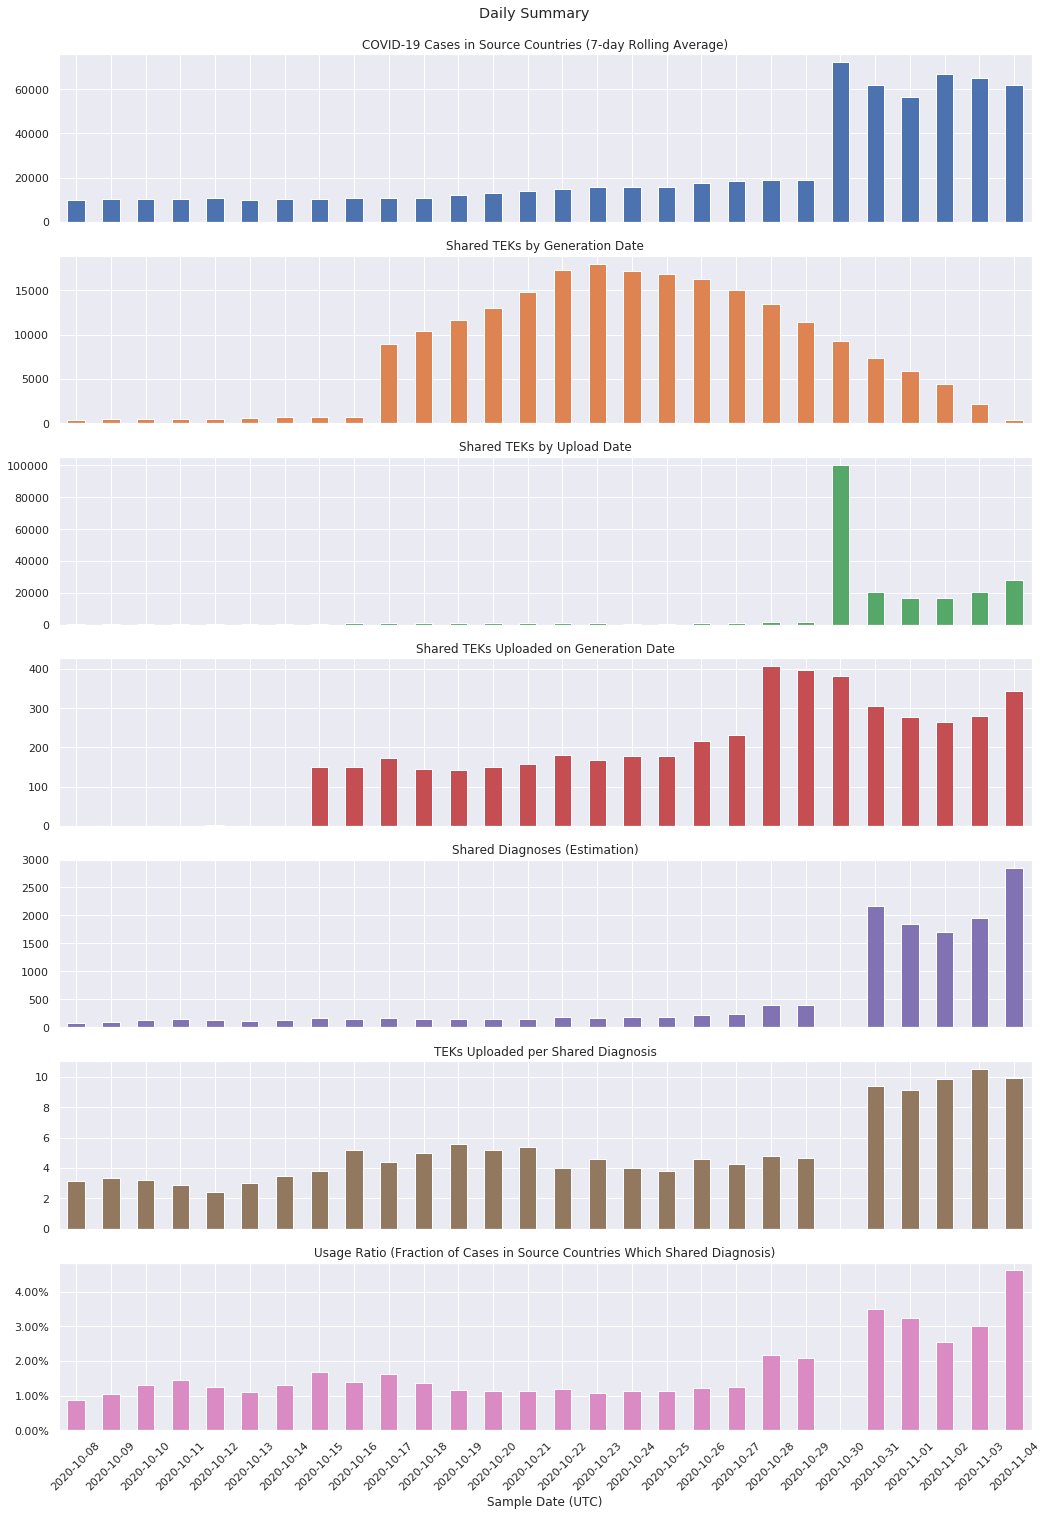

In [52]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .droplevel(level=["source_regions"]) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Daily Generation to Upload Period Table

In [53]:
display_generation_to_upload_period_pivot_df = \
    generation_to_upload_period_pivot_df \
        .head(backend_generation_days)
display_generation_to_upload_period_pivot_df \
    .head(backend_generation_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping)

Generation to Upload Period in Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Upload Date (UTC),,,,,,,,,,,,,,
2020-11-04,344,1838,2851,2522,2429,2336,2226,2120,2055,1992,1936,1890,1873,1835
2020-11-03,280,1325,1961,1888,1809,1711,1642,1564,1519,1448,1414,1388,1354,1310
2020-11-02,264,1156,1711,1629,1500,1415,1314,1250,1195,1163,1129,1100,1072,1029
2020-11-01,277,1038,1842,1654,1495,1375,1302,1241,1196,1168,1123,1075,1046,1016
2020-10-31,305,1273,2163,1934,1766,1671,1578,1507,1461,1416,1370,1326,1292,1266
2020-10-30,382,1743,4126,6104,7567,8436,9104,10138,9629,9129,8815,8563,8326,8153
2020-10-29,397,333,285,237,183,139,82,59,50,30,22,14,10,6
2020-10-28,406,362,328,263,204,138,88,62,35,17,10,7,7,6
2020-10-27,231,187,164,123,98,77,44,28,22,11,3,0,0,0


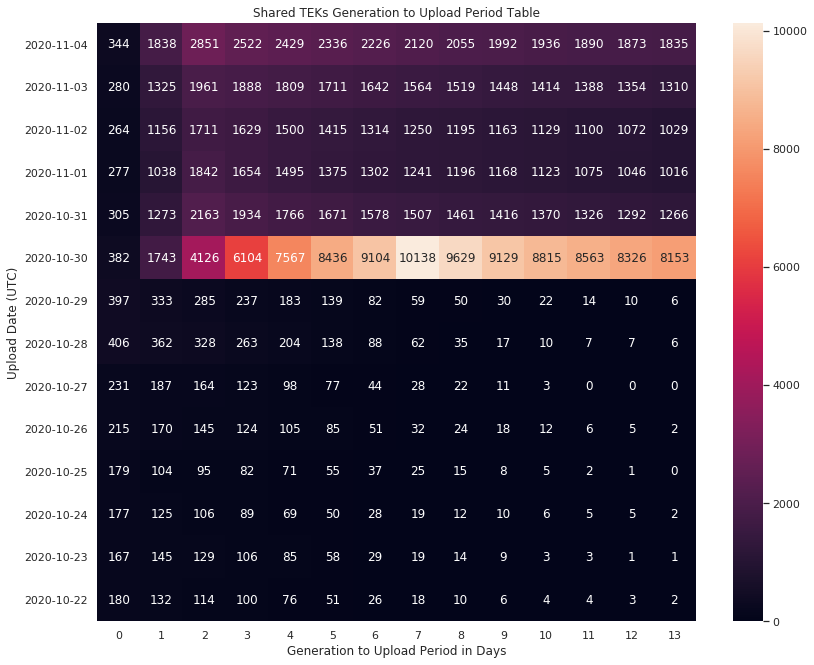

In [54]:
fig, generation_to_upload_period_pivot_table_ax = plt.subplots(
    figsize=(12, 1 + 0.6 * len(display_generation_to_upload_period_pivot_df)))
generation_to_upload_period_pivot_table_ax.set_title(
    "Shared TEKs Generation to Upload Period Table")
sns.heatmap(
    data=display_generation_to_upload_period_pivot_df
        .rename_axis(columns=display_column_name_mapping)
        .rename_axis(index=display_column_name_mapping),
    fmt=".0f",
    annot=True,
    ax=generation_to_upload_period_pivot_table_ax)
generation_to_upload_period_pivot_table_ax.get_figure().tight_layout()

### Hourly Summary Plots 

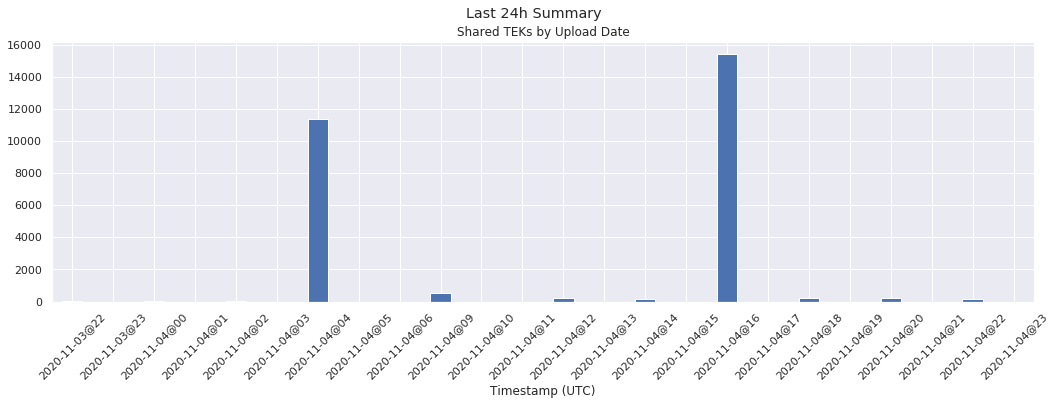

In [55]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [56]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [57]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

display_formatters = {
    display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
    display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
}
daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(formatters=display_formatters)
multi_backend_summary_table_html = multi_backend_summary_df \
    .head(daily_plot_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(formatters=display_formatters)

def format_multi_backend_cross_sharing_fraction(x):
    if pd.isna(x):
        return "-"
    elif round(x * 100, 1) == 0:
        return ""
    else:
        return f"{x:.1%}"

multi_backend_cross_sharing_summary_table_html = multi_backend_cross_sharing_summary_df \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(
        classes="table-center",
        formatters=display_formatters,
        float_format=format_multi_backend_cross_sharing_fraction)
multi_backend_cross_sharing_summary_table_html = \
    multi_backend_cross_sharing_summary_table_html \
        .replace("<tr>","<tr style=\"text-align: center;\">")

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index.get_level_values("sample_date") == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.sum()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.sum()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.sum()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.sum()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.sum()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.sum()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)

display_source_regions = ", ".join(report_source_regions)

if len(report_source_regions) == 1:
    display_brief_source_regions = report_source_regions[0]
else:
    display_brief_source_regions = f"{len(report_source_regions)} 🇪🇺"

In [58]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_backend_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_backend_summary_df)
generation_to_upload_period_pivot_table_image_path = save_temporary_plot_image(
    ax=generation_to_upload_period_pivot_table_ax)

### Save Results

In [59]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(
    report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(
    report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(
    report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_backend_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Summary-Table.csv")
multi_backend_cross_sharing_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Cross-Sharing-Summary-Table.csv")
generation_to_upload_period_pivot_df.to_csv(
    report_resources_path_prefix + "Generation-Upload-Period-Table.csv")
_ = shutil.copyfile(
    summary_plots_image_path,
    report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(
    summary_table_image_path,
    report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(
    hourly_summary_plots_image_path,
    report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(
    multi_backend_summary_table_image_path,
    report_resources_path_prefix + "Multi-Backend-Summary-Table.png")
_ = shutil.copyfile(
    generation_to_upload_period_pivot_table_image_path,
    report_resources_path_prefix + "Generation-Upload-Period-Table.png")

### Publish Results as JSON

In [60]:
summary_results_api_df = result_summary_df.reset_index()
summary_results_api_df["sample_date_string"] = \
    summary_results_api_df["sample_date"].dt.strftime("%Y-%m-%d")
summary_results_api_df["source_regions"] = \
    summary_results_api_df["source_regions"].apply(lambda x: x.split(","))

today_summary_results_api_df = \
    summary_results_api_df.to_dict(orient="records")[0]

summary_results = dict(
    backend_identifier=report_backend_identifier,
    source_regions=report_source_regions,
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=0,
    ),
    today=today_summary_results_api_df,
    last_7_days=last_7_days_summary,
    daily_results=summary_results_api_df.to_dict(orient="records"))
summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [61]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    extraction_date_with_hour=extraction_date_with_hour,
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    multi_backend_summary_table_html=multi_backend_summary_table_html,
    multi_backend_cross_sharing_summary_table_html=multi_backend_cross_sharing_summary_table_html,
    display_source_regions=display_source_regions)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [62]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule" and \
        (shared_teks_by_upload_date_last_hour or not are_today_results_partial):
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    generation_to_upload_period_pivot_table_image_media = api.media_upload(generation_to_upload_period_pivot_table_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        generation_to_upload_period_pivot_table_image_media.media_id,
    ]

    if are_today_results_partial:
        today_addendum = " (Partial)"
    else:
        today_addendum = ""

    status = textwrap.dedent(f"""
        #RadarCOVID – {extraction_date_with_hour}

        Source Countries: {display_brief_source_regions}

        Today{today_addendum}:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f}
        - Usage Ratio: ≤{shared_diagnoses_per_covid_case:.2%}

        Last 7 Days:
        - Shared Diagnoses: ≤{last_7_days_summary["shared_diagnoses"]:.0f}
        - Usage Ratio: ≤{last_7_days_summary["shared_diagnoses_per_covid_case"]:.2%}

        Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)